In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

def get_runs_df(runs):
    summary_list, config_list, name_list, metrics_list = [], [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        history = run.history()
        
        # Extract specific metrics from history
        metrics = {
            "train/loss": history["train/loss"].tolist() if "train/loss" in history else None,
            "train/ppl": history["train/ppl"].tolist() if "train/ppl" in history else None,
            "val/loss": history["val/loss"].tolist() if "val/loss" in history else None,
            "val/ppl": history["val/ppl"].tolist() if "val/ppl" in history else None,
        }
        metrics_list.append(metrics)

        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "metrics": metrics_list
        })
    return runs_df

In [10]:
import os
import numpy as np

import matplotlib.pyplot as plt

# Функция для извлечения метрик и усреднения по рестартам
def process_metrics(runs_df, metric_key):
    metrics_data = {}
    for _, row in runs_df.iterrows():
        method_name = "_".join(row['name'].split("_")[:-2])
        if method_name not in metrics_data:
            metrics_data[method_name] = []
        metrics_data[method_name].append(row['metrics'][metric_key])
    
    # Усреднение и расчет дисперсии
    averaged_metrics = {}
    for method, values in metrics_data.items():
        values = np.array(values)
        averaged_metrics[method] = {
            'mean': np.mean(values, axis=0),
            'std': np.std(values, axis=0)
        }
    return averaged_metrics


# Функция для построения графиков
def plot_metrics(metrics, title, ylabel, save=False, save_path=None):
    plt.figure(figsize=(10, 8))  # Default size for better visibility
    for method, data in metrics.items():
        epochs = range(len(data['mean']))
        method_name = '_'.join(method.split('_')[:-1])
        lr = method.split('_')[-1]
        if ylabel == "Perplexity":
            plt.semilogy(epochs, data['mean'], label=f'{method_name}, {lr=:}', linewidth=2)
        else:
            plt.plot(epochs, data['mean'], label=f'{method_name}, {lr=:}', linewidth=2)
        plt.fill_between(epochs, 
                         data['mean'] - data['std'], 
                         data['mean'] + data['std'], 
                         alpha=0.3)
    scale = 1.5
    plt.title(title, fontsize=28*scale)
    plt.xlabel("Epochs", fontsize=24*scale)
    plt.ylabel(ylabel, fontsize=24*scale)
    plt.xticks(fontsize=20*scale)
    plt.yticks(fontsize=20*scale)
    plt.legend(fontsize=18*scale, loc='upper right')
    plt.grid(True, linestyle='--', linewidth=1.0)
    plt.tight_layout()
    if save:
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path)
        path = f"{save_path}/{title}.pdf" if save_path else f"{title}.pdf"
        plt.savefig(path, dpi=300)
    else:
        plt.show()

# Experiment 1

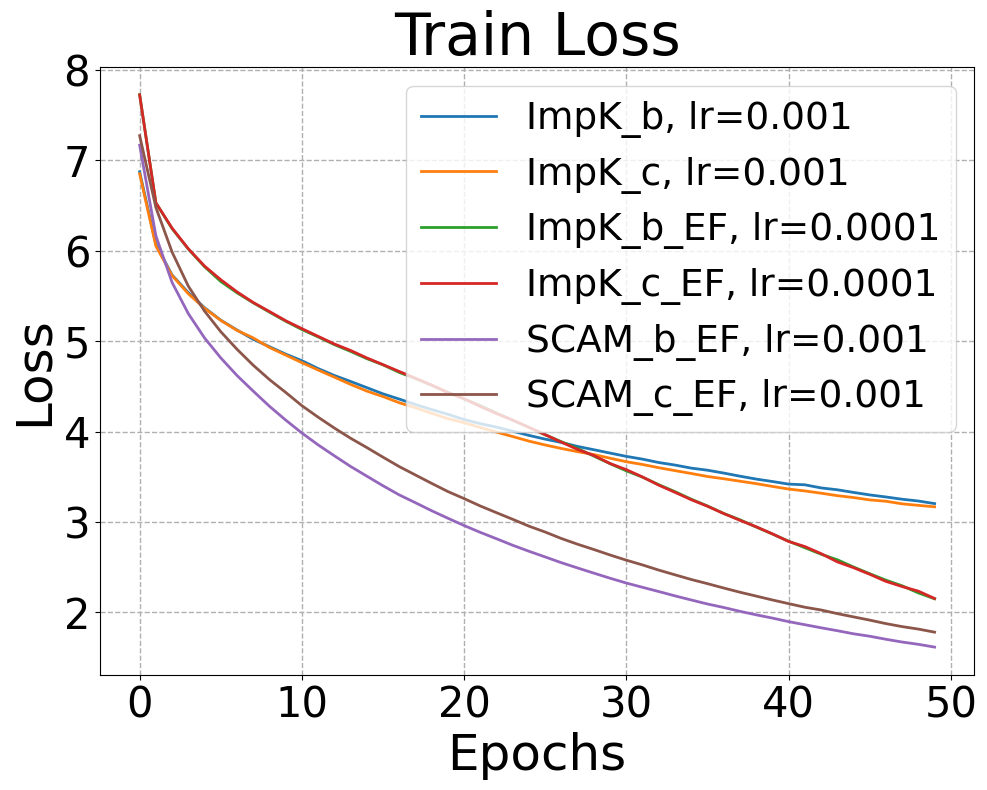

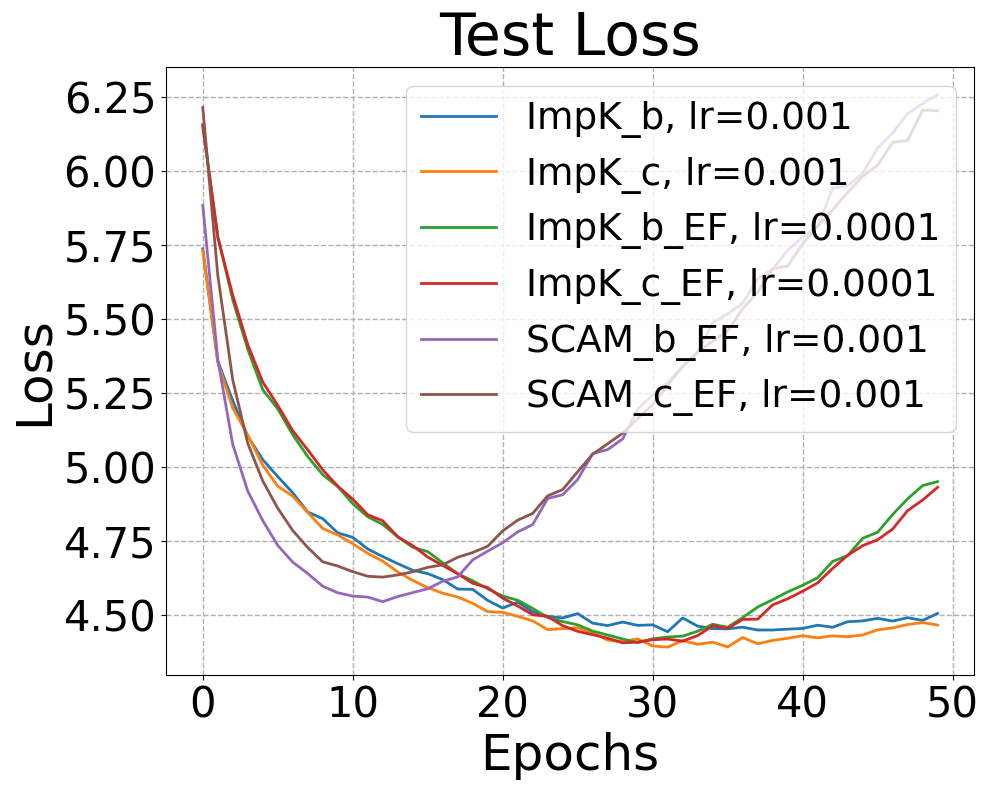

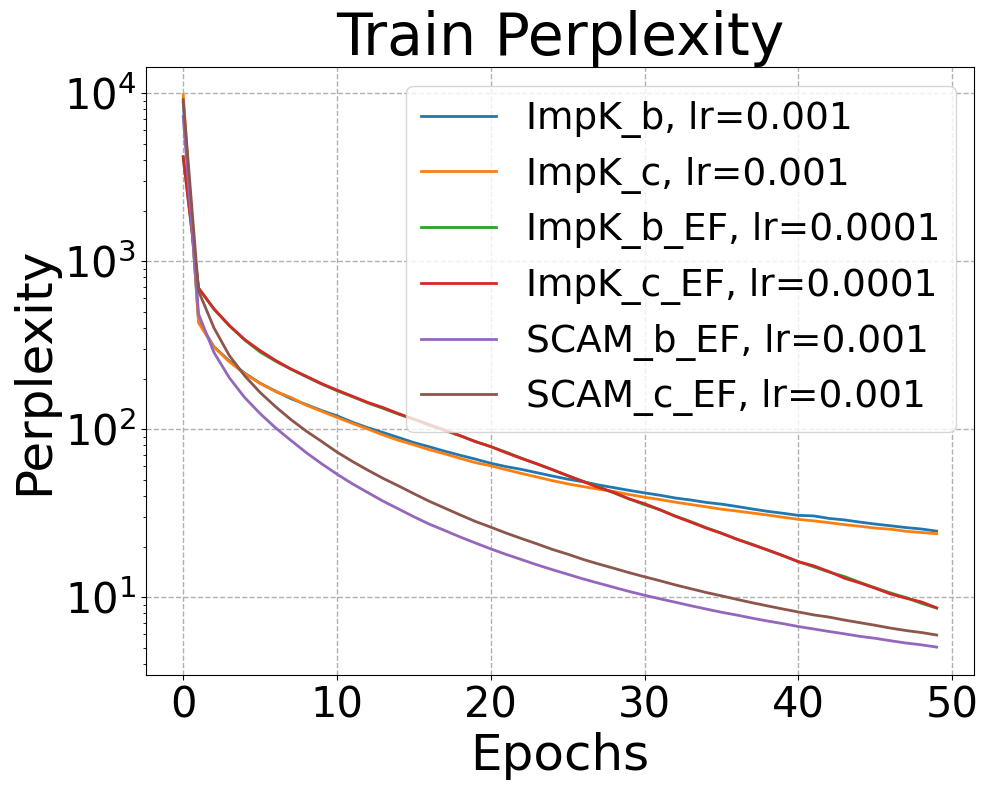

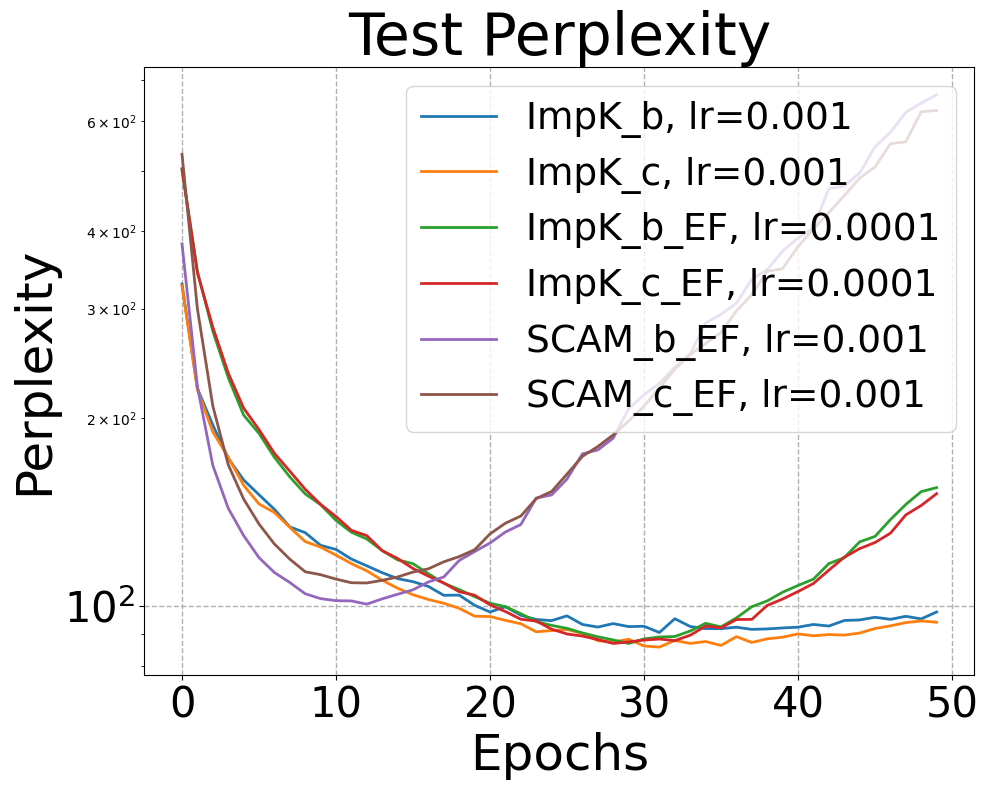

In [11]:
# Project is specified by <entity/project-name>
runs = api.runs("khafizov-research/Transformer-Experiment1")

runs_df = get_runs_df(runs)

runs_df.to_csv("experiment1.csv", index=False)

# Обработка метрик
train_loss = process_metrics(runs_df, 'train/loss')
val_loss = process_metrics(runs_df, 'val/loss')
train_acc = process_metrics(runs_df, 'train/ppl')
val_acc = process_metrics(runs_df, 'val/ppl')


# Построение графиков
plot_metrics(train_loss, "Train Loss", "Loss", save=True, save_path="experiment1")
plot_metrics(val_loss, "Test Loss", "Loss", save=True, save_path="experiment1")
plot_metrics(train_acc, "Train Perplexity", "Perplexity", save=True, save_path="experiment1")
plot_metrics(val_acc, "Test Perplexity", "Perplexity", save=True, save_path="experiment1")

# Experiment 2

In [12]:
SCAM_b_EF = runs_df.loc[runs_df["name"].str.contains("SCAM_b_EF")]

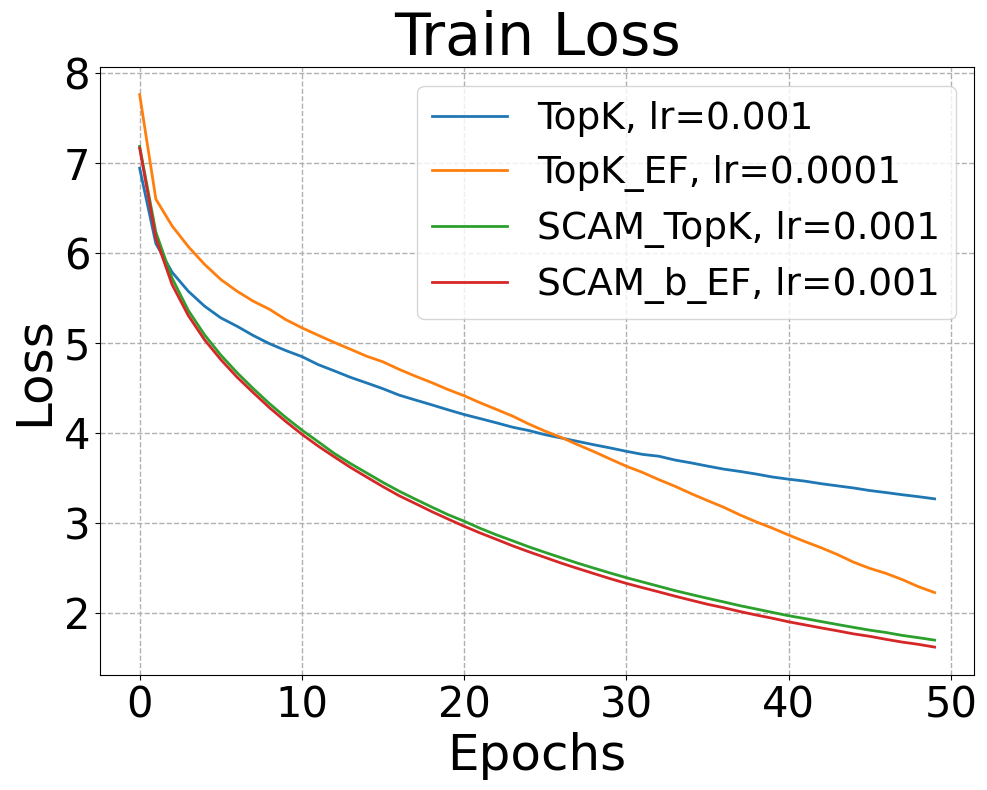

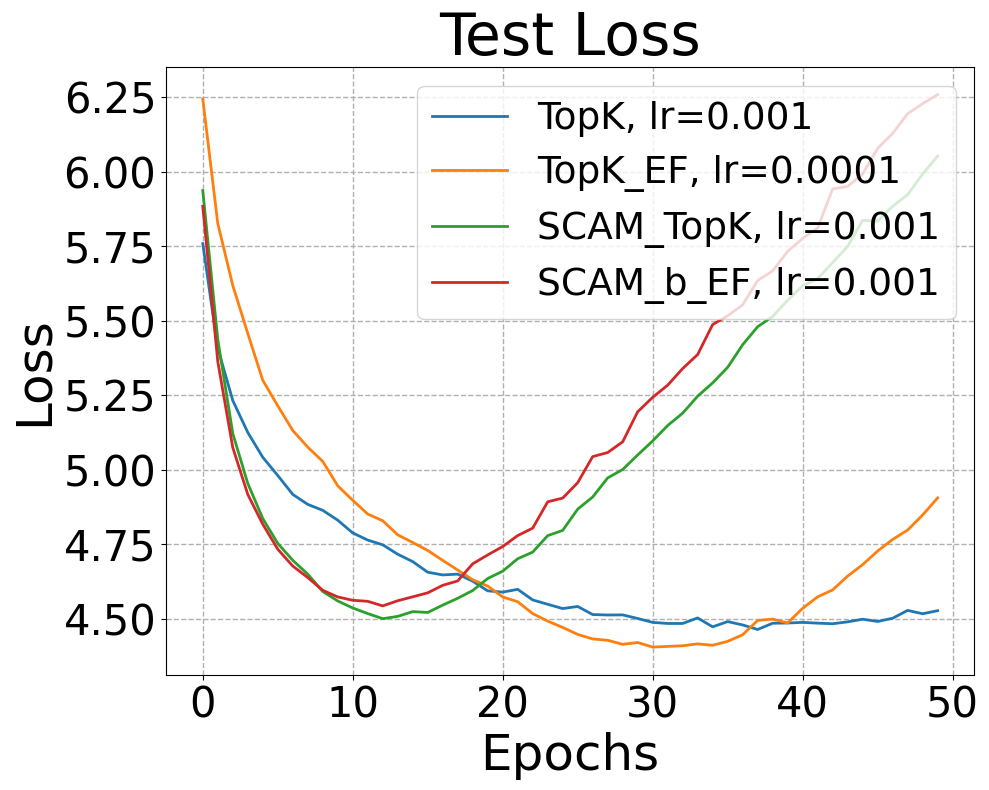

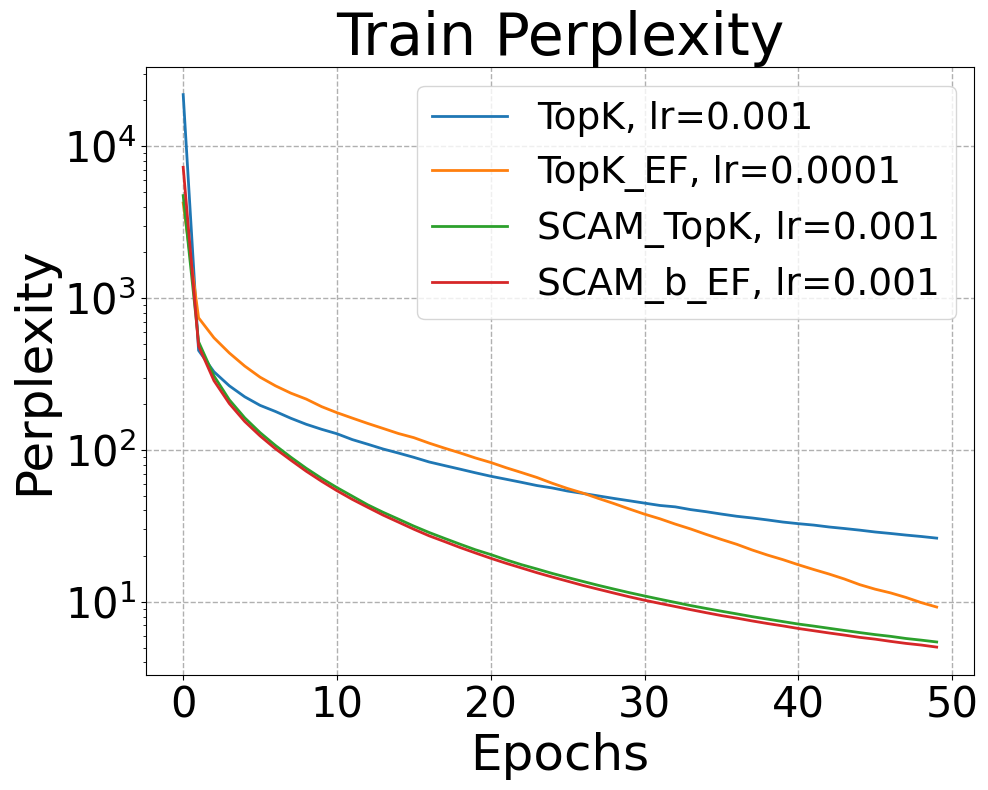

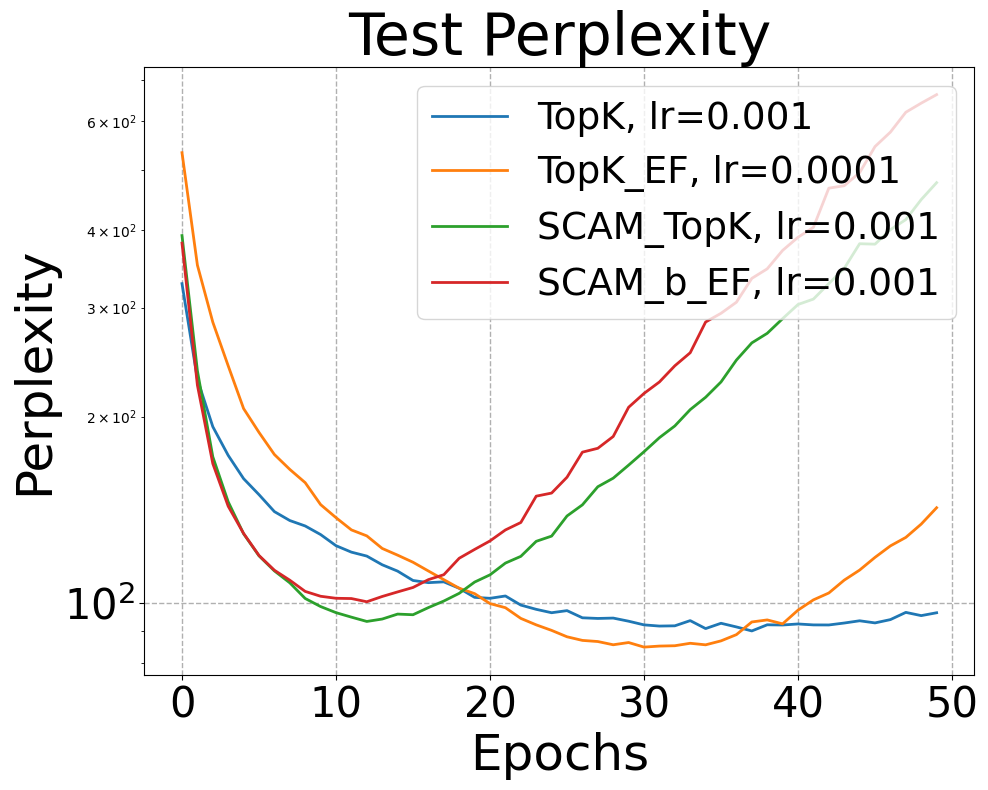

In [13]:
# Project is specified by <entity/project-name>
runs = api.runs("khafizov-research/Transformer-Experiment2")

runs_df = get_runs_df(runs)

runs_df = pd.concat([runs_df, SCAM_b_EF], ignore_index=True)

runs_df.to_csv("experiment1.csv", index=False)

# Обработка метрик
train_loss = process_metrics(runs_df, 'train/loss')
val_loss = process_metrics(runs_df, 'val/loss')
train_acc = process_metrics(runs_df, 'train/ppl')
val_acc = process_metrics(runs_df, 'val/ppl')

save_path = "experiment2"

# Построение графиков
plot_metrics(train_loss, "Train Loss", "Loss", save=True, save_path=save_path)
plot_metrics(val_loss, "Test Loss", "Loss", save=True, save_path=save_path)
plot_metrics(train_acc, "Train Perplexity", "Perplexity", save=True, save_path=save_path)
plot_metrics(val_acc, "Test Perplexity", "Perplexity", save=True, save_path=save_path)